# Model Selection Tutorial with Yellowbrick

In this tutorial, we are going to look at scores for a variety of [scikit-learn](http://scikit-learn.org) models and compare them using visual diagnostic tools from [Yellowbrick](http://www.scikit-yb.org) in order to select the best model for our data. 


## The Model Selection Triple

Discussions of machine learning are frequently characterized by a singular focus on model selection. Be it logistic regression, random forests, Bayesian methods, or artificial neural networks, machine learning practitioners are often quick to express their preference. The reason for this is mostly historical. Though modern third-party machine learning libraries have made the deployment of multiple models appear nearly trivial, traditionally the application and tuning of even one of these algorithms required many years of study. As a result, machine learning practitioners tended to have strong preferences for particular (and likely more familiar) models over others.

However, model selection is a bit more nuanced than simply picking the "right" or "wrong" algorithm. In practice, the workflow includes:

  1. selecting and/or engineering the smallest and most predictive feature set
  2. choosing a set of algorithms from a model family, and
  3. tuning the algorithm hyperparameters to optimize performance.

The **model selection triple** was first described in a 2015 [SIGMOD](http://cseweb.ucsd.edu/~arunkk/vision/SIGMODRecord15.pdf) paper by Kumar et al. In their paper, which concerns the development of next-generation database systems built to anticipate predictive modeling, the authors cogently express that such systems are badly needed due to the highly experimental nature of machine learning in practice. "Model selection," they explain, "is iterative and exploratory because the space of [model selection triples] is usually infinite, and it is generally impossible for analysts to know a priori which [combination] will yield satisfactory accuracy and/or insights."

Recently, much of this workflow has been automated through grid search methods, standardized APIs, and GUI-based applications. In practice, however, human intuition and guidance can more effectively hone in on quality models than exhaustive search. By visualizing the model selection process, data scientists can steer towards final, explainable models and avoid pitfalls and traps.

The Yellowbrick library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. Yellowbrick extends the scikit-learn API with a new core object: the Visualizer. Visualizers allow visual models to be fit and transformed as part of the scikit-learn `Pipeline` process, providing visual diagnostics throughout the transformation of high dimensional data.


## About the Data

This tutorial uses the mushrooms data from the Yellowbrick :doc:`api/datasets` module. Our objective is to predict if a mushroom is poisonous or edible based on its characteristics.

_NOTE: The YB version of the mushrooms data differs from the mushroom dataset from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/). The Yellowbrick version has been deliberately modified to make modeling a bit more of a challenge._

The data include descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species was identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended (this latter class was combined with the poisonous one).

Our file, "agaricus-lepiota.txt," contains information for 3 nominally valued attributes and a target value from 8124 instances of mushrooms (4208 edible, 3916 poisonous).

Let's load the data:

In [1]:
from yellowbrick.datasets import load_mushroom

X, y = load_mushroom()
print(X[:5]) # inspect the first five rows

    shape surface   color
0  convex  smooth  yellow
1    bell  smooth   white
2  convex   scaly   white
3  convex  smooth    gray
4  convex   scaly  yellow


## Feature Extraction 

Our data, including the target, is categorical. We will need to change these values to numeric ones for machine learning. In order to extract this from the dataset, we'll have to use scikit-learn transformers to transform our input dataset into something that can be fit to a model. Luckily, scikit-learn does provide transformers for converting categorical labels into numeric integers: [`sklearn.preprocessing.LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) and [`sklearn.preprocessing.OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

We'll use a combination of scikit-learn's `Pipeline` object ([here's great post on using pipelines](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html) by [Zac Stewart](https://twitter.com/zacstewart)), `OneHotEncoder`, and `LabelEncoder`:

```python
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


y = LabelEncoder().fit_transform(y) # Label-encode targets before modeling
model = Pipeline([
     ('one_hot_encoder', OneHotEncoder()), # One-hot encode columns before modeling
     ('estimator', estimator)
])
```

## Modeling and Evaluation

### Common metrics for evaluating classifiers

**Precision** is the number of correct positive results divided by the number of all positive results (e.g. _How many of the mushrooms we predicted would be edible actually were?_).

**Recall** is the number of correct positive results divided by the number of positive results that should have been returned (e.g. _How many of the mushrooms that were poisonous did we accurately predict were poisonous?_).

The **F1 score** is a measure of a test's accuracy. It considers both the precision and the recall of the test to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst at 0.

    precision = true positives / (true positives + false positives)

    recall = true positives / (false negatives + true positives)

    F1 score = 2 * ((precision * recall) / (precision + recall))


Now we're ready to make some predictions!

Let's build a way to evaluate multiple estimators &mdash;  first using traditional numeric scores (which we'll later compare to some visual diagnostics from the Yellowbrick library).

In [2]:
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [3]:
# Try them all!
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
 
    
models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

SVC: 0.6624286455630514
NuSVC: 0.6726016476215785
LinearSVC: 0.6583804143126177
SGDClassifier: 0.5582697992842696
KNeighborsClassifier: 0.6581185045215279
LogisticRegression: 0.6580434509606933
LogisticRegressionCV: 0.6583804143126177
BaggingClassifier: 0.6879633373770051
ExtraTreesClassifier: 0.6871364804544838
RandomForestClassifier: 0.687643484132343


### Preliminary Model Evaluation

Based on the results from the F1 scores above, which model is performing the best?

## Visual Model Evaluation

Now let's refactor our model evaluation function to use Yellowbrick's `ClassificationReport` class, a model visualizer that displays the precision, recall, and F1 scores. This visual model analysis tool integrates numerical scores as well color-coded heatmap in order to support easy interpretation and detection, particularly the nuances of Type I and Type II error, which are very relevant (lifesaving, even) to our use case!


**Type I error** (or a **"false positive"**) is detecting an effect that is not present (e.g. determining a mushroom is poisonous when it is in fact edible).

**Type II error** (or a **"false negative"**) is failing to detect an effect that is present (e.g. believing a mushroom is edible when it is in fact poisonous).

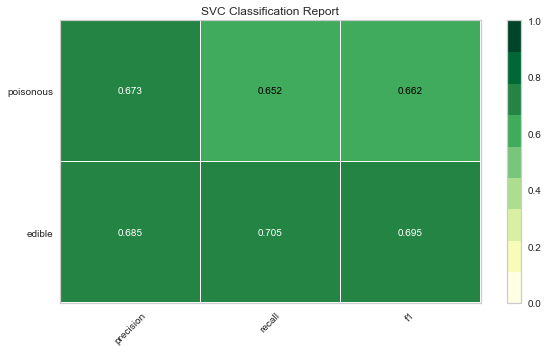

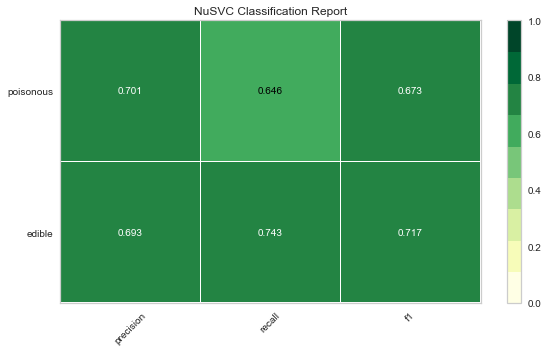

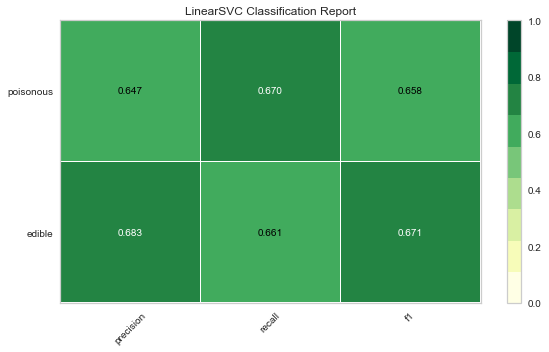

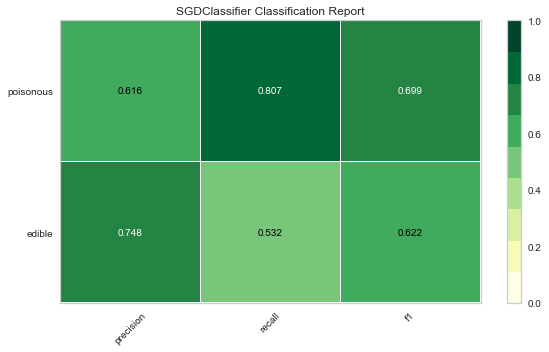

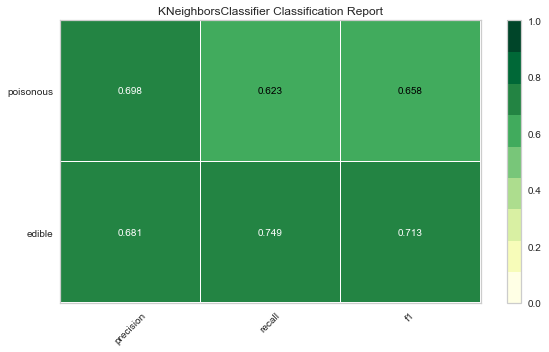

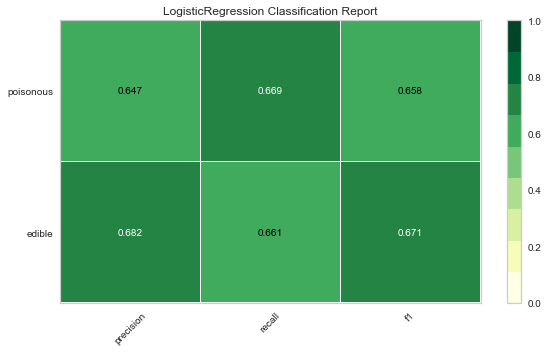

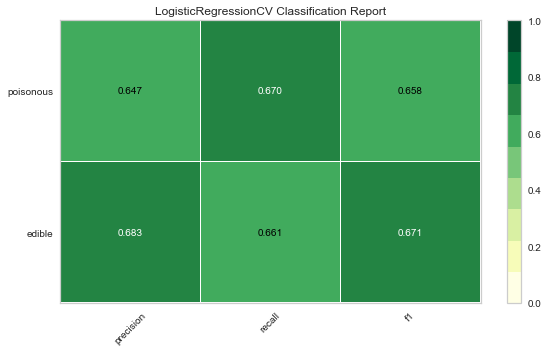

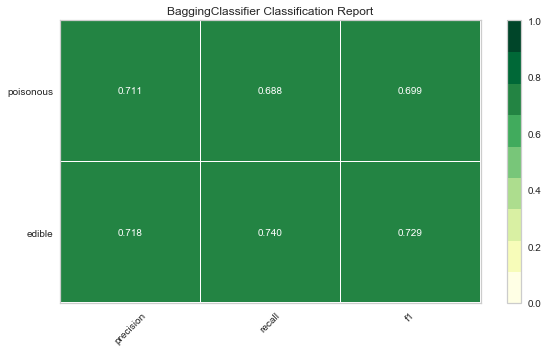

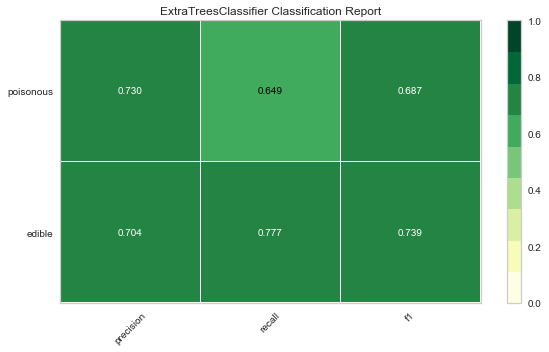

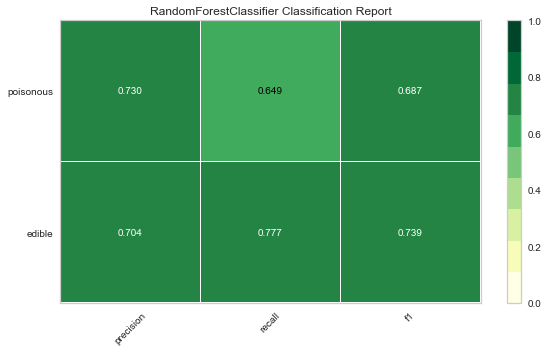

In [7]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport


def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=['edible', 'poisonous'], 
        cmap="YlGn", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)

## Reflection

 1. Which model seems best now? Why?
 2. Which is most likely to save your life?
 3. How is the visual model evaluation experience different from numeric model evaluation?